In [1]:
# Load the necessary libraries
import pandas as pd
#data comes from: 
#http://service.iris.edu/fdsnws/dataselect/1/query?net=CU&sta=GRTK&loc=00&cha=BHZ&starttime=2024-09-06T00:00:00&endtime=2024-09-06T00:01:00&format=csv

from obspy import read
from io import BytesIO
import requests

# Define the MiniSEED data URL
url = 'http://service.iris.edu/fdsnws/dataselect/1/query?net=CU&sta=GRTK&loc=00&cha=BHZ&starttime=2024-09-06T00:00:00&endtime=2024-09-06T00:01:00&format=miniseed'

# Fetch the data from the URL
response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Read the MiniSEED data into an ObsPy Stream object
stream = read(BytesIO(response.content))

# Convert the Stream into a Trace object (there may be multiple Traces in a Stream)
trace = stream[0]

# Create a DataFrame from the Trace data
# Extract the time vector and the waveform data (trace data)
time = trace.times("timestamp")  # get timestamps
data = trace.data  # get the waveform data

# Create the DataFrame
df = pd.DataFrame({'Time': time, 'Amplitude': data})

# Display the first few rows of the DataFrame
print(df.head())


           Time  Amplitude
0  1.725581e+09       7046
1  1.725581e+09       6225
2  1.725581e+09       6959
3  1.725581e+09       6878
4  1.725581e+09       6834


In [2]:

# Load the CSV file into a DataFrame
#file_path = '../data/CU.GRTK.00.BHZ.M.2024-09-06T000000.019539.csv'
#df = pd.read_csv(file_path, comment='#')

#Time, Sample 2024-09-06T00:00:00.019539Z, 7046


# Convert DATE and TIME to a single datetime column and round up to the next hour
df['DATETIME'] = pd.to_datetime(df['Time'])
#df['DATETIME'] = df['DATETIME'].dt.ceil('h')  # Round to the next hour

# Set DATETIME as the index
df.set_index('DATETIME', inplace=True)

df_data = df[[' Sample']]


KeyError: "None of [Index([' Sample'], dtype='object')] are in the [columns]"

In [10]:
df_data.head()

,Sample
DATETIME,
2024-09-06 00:00:00.019539+00:00,7046
2024-09-06 00:00:00.044539+00:00,6225
2024-09-06 00:00:00.069539+00:00,6959
2024-09-06 00:00:00.094539+00:00,6878
2024-09-06 00:00:00.119539+00:00,6834


In [11]:
rows = len(df_data)
print(rows)

9600


In [12]:
df_data.shape

(9600, 1)

In [13]:
import numpy as np


# Assuming df_data has 9600 rows
rows = len(df_data)  # Total number of rows in the DataFrame (9600)
target_rows = 1800  # Desired number of rows after downsampling

# Calculate the number of rows per group (group size)
group_size = rows / target_rows  # This results in 5.3333...

# Create groups dynamically using np.floor(np.arange())
df_data['group'] = np.floor(np.arange(rows) / group_size).astype(int)

# Now downsample by taking the mean (or max) of each group
downsampled_df = df_data.groupby('group').max()  # Or use .max(), depending on your requirement

# Drop the 'group' column if necessary
# downsampled_df.drop(columns='group', inplace=True)

# Display the first few rows of the downsampled DataFrame
downsampled_df.head()


,Sample
group,
0,7550
1,8189
2,8838
3,9652
4,10199


In [14]:
downsampled_df.shape

(1800, 1)

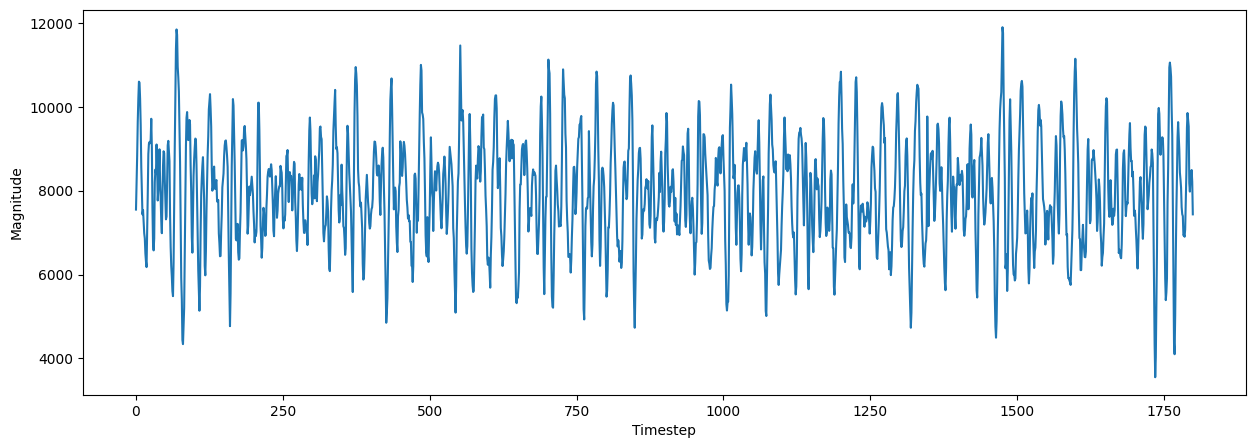

In [15]:
#graph
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(downsampled_df.index,downsampled_df[" Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig("../img/seismic_realtime.png")

In [33]:
downsampled_df.to_csv("../data/seismic_1800.csv", index = True)

In [34]:
#normalize and park at 3600


# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
normalized_sample = (downsampled_df[' Sample'] - downsampled_df[' Sample'].min()) / (downsampled_df[' Sample'].max() - downsampled_df[' Sample'].min())

# Create a new DataFrame with an index from 0 to 7199
new_df = pd.DataFrame(index=np.arange(7200))

# Fill the new DataFrame with 0.0 values initially
new_df[' Sample'] = 0.0

# Find the start index to center the data at index 3599
start_idx = 3599

# Place the normalized data in the new DataFrame starting at 'start_idx'
new_df.loc[start_idx:start_idx + len(normalized_sample) - 1, ' Sample'] = normalized_sample.values

# Display the resulting DataFrame
new_df.head(10), new_df.tail(10)


(   Sample
 0     0.0
 1     0.0
 2     0.0
 3     0.0
 4     0.0
 5     0.0
 6     0.0
 7     0.0
 8     0.0
 9     0.0,
       Sample
 7190     0.0
 7191     0.0
 7192     0.0
 7193     0.0
 7194     0.0
 7195     0.0
 7196     0.0
 7197     0.0
 7198     0.0
 7199     0.0)

In [35]:
new_df.dtypes

Sample    float64
dtype: object

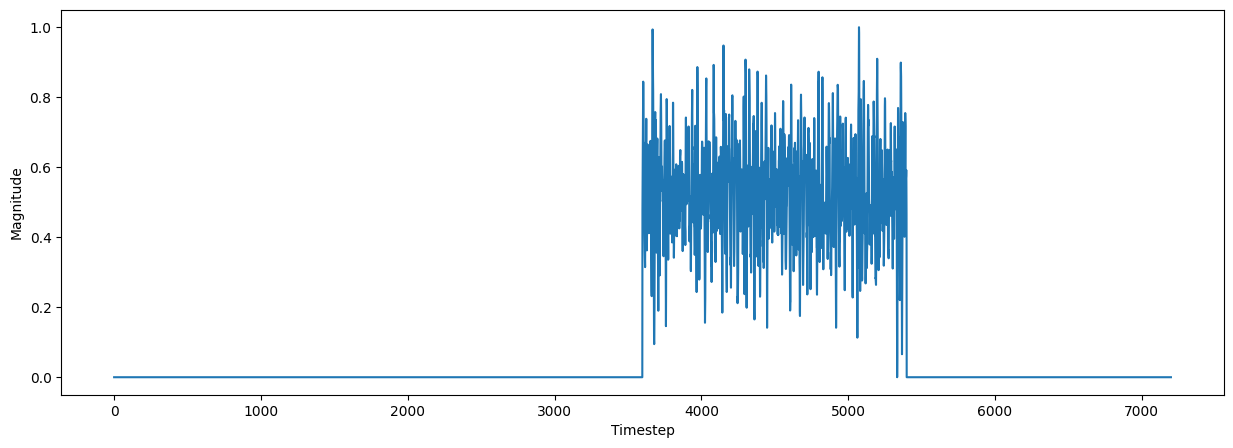

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(new_df.index,new_df[" Sample"])
plt.xlabel('Timestep')
plt.ylabel('Magnitude')
plt.savefig("../img/seismic_realtime_7200.png")

In [37]:
new_df.to_csv("../data/seismic_7200.csv", index = True)